Basic Walkthrough:
     1) Define everything
     2) Create master bias file, Save master bias file  
     3) Open all other files, sub master bias, save  (*c?.b.fits)
     4) Remove cosmics from all file types except bias  (*c?.bc.fits)
     5) Open flats and create master skyflat file, save
     6) Open all remainging types and divide out master flat, then save  (*c?.bcf.fits)
     7) Open all remaining types and stitch together, save  (*full.bcf.fits)
     8) Use fibermap files to determine aperatures
     9) Use aperatures to cut out same regions in thar,comp,science
     10) Save all 256 to files with their header tagged name in filename, along with fiber num
     11) Assume no curvature within tiny aperature region; fit profile to 2d spec and sum to 1d
     12) Fit the lines in comp spectra, save file and fit solution
     13) Try to fit lines in thar spectra, save file and fit solution
     14) Apply to science spectra

In [1]:
import os
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Define input file numbers and other required information

Ex:

    Bias 597-626
    ThAr 627,635
    NeHgArXe 628,629,636,637
    Science 631-634
    Fibermaps 573-577


In [2]:
thar_lamps = np.asarray([627,635])
comp_lamps = np.asarray([628,629,636,637])
sciences = np.arange(631,634+1).astype(int)

In [3]:
instrument = 'M2FS'
mask_name = 'A02'
cal_lamp = ['Xenon', 'Argon', 'HgNe']  # 'Xenon','Argon','Neon', 'HgNe'
cameras = ['r']
opamps = [1,2,3,4]

In [4]:
path_to_masks = os.path.abspath('../../OneDrive/Research/M2FSReductions')
mask_subdir = mask_name
raw_data_subdir =  'raw_data'
raw_filename_template = '{cam}{filenum:04d}c{opamp}.fits'

###         Beginning of Code

In [5]:
date = np.datetime_as_string(np.datetime64('today', 'D'))

In [6]:
mask_dir = os.path.join(path_to_masks,mask_subdir)

In [7]:
raw_data_dir =     os.path.join(mask_dir, raw_data_subdir)
raw_stitched_dir = os.path.join(mask_dir,'raw_stitched')
product_dir =      os.path.join(mask_dir,'data_products')
twod_dir =         os.path.join(mask_dir,'twods')
oned_dir =         os.path.join(mask_dir,'oneds')
calibrated_dir =   os.path.join(mask_dir,'calibrated_oned')
summedspec_dir =   os.path.join(mask_dir,'final_oned')
zfit_dir =         os.path.join(mask_dir,'zfits')

for folder in [ raw_data_dir, raw_stitched_dir, product_dir, twod_dir, 
    oned_dir, calibrated_dir, summedspec_dir, zfit_dir]:
    if not os.path.exists(folder):
        os.makedirs(folder)

In [8]:
fibermap_array_dict, fibermap_header_dict = None,None
twiflat_array_dict, twiflat_header_dict = None,None
bias_array_dict, bias_header_dict = None,None

In [9]:
headers = None
data = None
master_aux_data = {}
master_aux_headers = {}

In [10]:
filenumbers = {'thar':thar_lamps, 'comp': comp_lamps, 'science': sciences}

In [11]:
base_file_template =          '{cam}_{imtype}_{filenum:04d}_{maskname}_'
stitched_filename_template =  base_file_template+'stitched{tags}.fits'
twod_filename_template =      base_file_template+'{fibername}_2d{tags}.fits'
oned_filename_template =      base_file_template+'{fibername}_1d{tags}.fits'
combined_filename_template =  base_file_template+'{fibername}_combined_1d{tags}.fits'

master_stitched_fname_template =  '{cam}_master{imtype}_{maskname}_stitched{tags}.fits'

In [12]:
common_info =      {    'maskname':         mask_name,
                        'cameras':          cameras,
                        'opamps':           opamps, 
                        'date':             date,
                        'datadir':          raw_data_dir,
                        'template':         raw_filename_template,
                        'master_template':  master_stitched_fname_template,
                        'master_types':     [],
                        'tags':             ''                      }

In [13]:
## fast forward to apcut
common_info['master_types'] = ['fibmap','twiflat']#,,'bias']
common_info['tags'] = '.bc'
common_info['datadir'] = product_dir
common_info['template'] = stitched_filename_template

In [14]:
from quickreduce_funcs import get_all_filedata
data, headers = get_all_filedata( filenum_dict=filenumbers, **common_info )

In [15]:
import cv2

In [16]:
#from opencv_work import *

In [17]:
#data['science']['r'][2][632]

In [18]:
img = data['fibmap']['r']
science_img = data['science']['r'][2][632].copy()
comp_img = data['comp']['r'][2][636].copy()


In [19]:
def imageset(img):
    cimg = img - np.min(img) + 1e-4
    log_img = np.log(cimg)

    pre_normd = cimg
    normalized = np.float64(pre_normd)/np.max(pre_normd)
    int_img = np.uint8(normalized*(2**8))
    outset = {}
    outset['raw'] = img
    outset['zerod'] = cimg
    outset['log'] = log_img
    outset['normd'] = normalized
    outset['int'] = int_img
    return outset

In [20]:
fibermap = imageset(img)
science = imageset(science_img)
coparison_arc = imageset(comp_img)

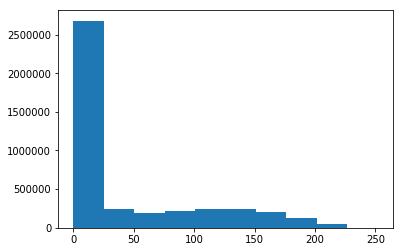

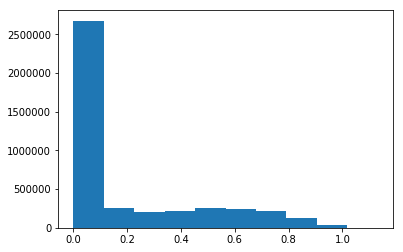

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

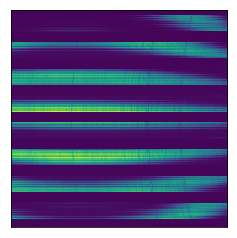

In [21]:
plt.figure()
plt.hist(fibermap['int'].ravel())
plt.show()
plt.figure()
plt.hist(fibermap['zerod'].ravel())
plt.show()
plt.figure()
plt.imshow(fibermap['int'])
plt.xticks([]), plt.yticks([])

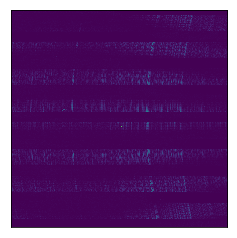

In [22]:
#from opencv_work import hufflines
cvimg = fibermap['int'].copy()

edge_detections = np.asarray(np.abs(cv2.Sobel(cvimg,cv2.CV_64F,1,0,ksize=3)) ).astype(np.uint8)

plt.imshow(edge_detections)
plt.xticks([]), plt.yticks([])
minLineLength = 10
maxLineGap = 400
lines = cv2.HoughLinesP(edge_detections.T,1,np.pi/180,100,minLineLength,maxLineGap)

In [23]:
def show_image(thisimg):
    cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    cv2.imshow('image',thisimg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [24]:
def gauss(xs,amp,mean,sigma):
    s2 = sigma*sigma
    x2 = (xs-mean)*(xs-mean)
    return amp*(1/np.sqrt(2*np.pi*s2))*np.exp(-x2/(2*s2))

In [25]:
# len_0 = int_img.shape[0]
# splits = 10
# span = int(len_0/splits)
# cuts = []
# for i in range(0,len_0,span):
#     sample = int_img[i:i+span,:]
#     cut = sample.sum(axis=0)
#     plt.figure()
#     plt.plot(range(len(cut)),cut)
#     plt.show()
#     cuts.append(cut)

# for cut in cuts:
#     normcut = cut/cuts[0]
#     plt.figure()
#     plt.plot(range(len(normcut)), normcut,'b-')
#     plt.show()

In [26]:
# copy_img = cimg.copy()
# nsteps = 16
# stepsize = int(copy_img.shape[1]/nsteps)

# slices = np.zeros(shape=(nsteps,copy_img.shape[0],stepsize))
# compact_slices = np.zeros(shape=(nsteps,copy_img.shape[0]))
# for i in range(nsteps):
#     curslice = copy_img[:,i*stepsize:(i+1)*stepsize]
#     slices[i,:,:] = curslice
#     compact_slice = curslice.sum(axis=1)
#     plt.figure(), plt.imshow(curslice.T)
#     plt.figure(), plt.plot(range(copy_img.shape[0]),compact_slice)

(<matplotlib.figure.Figure at 0x2cf549677b8>,
 [<matplotlib.lines.Line2D at 0x2cf53b37940>])

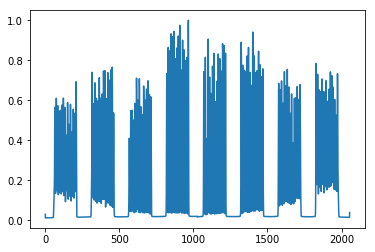

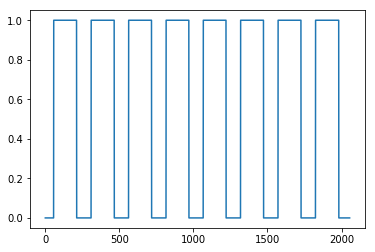

In [27]:
copy_img = fibermap['zerod'].copy()

sumd = copy_img.sum(axis=1)
sumd /= np.max(sumd)
plt.figure(), plt.plot(range(len(sumd)),sumd)
from scipy.signal import medfilt
medfiltd = medfilt(sumd,11)
binary = (medfiltd > 0.04).astype(int)
plt.figure(), plt.plot(range(len(binary)),binary)

[175 175 175 175 175 175 175 175]


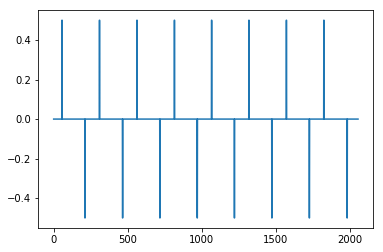

In [28]:
grad = np.gradient(binary)
plt.figure(), plt.plot(range(len(binary)),grad)
starts = np.where(grad>0)[0]
ends = np.where(grad<0)[0]
starts = starts[::2]-4
ends = ends[::2]+4

widths = ends-starts
med_width = np.median(widths)
width = min(np.max(widths),med_width+12)   

changes = widths - width - 10 # 10 is for padding
start_changes = np.floor(changes/2).astype(int)
end_changes = np.ceil(changes/2).astype(int)

starts += start_changes
ends -= end_changes

print(ends-starts)

175
175
175
175
175
175
175
175


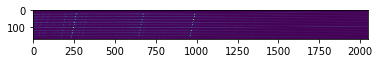

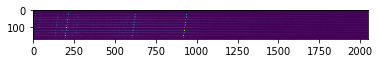

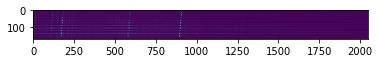

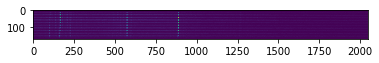

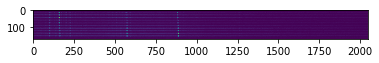

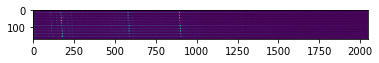

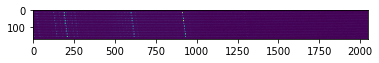

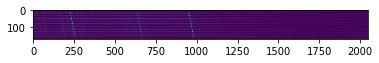

In [29]:
tetri = []
sci_tetri = []
comp_tetri = []
tetri_masks = []

for start,end in zip(starts,ends):
    print(end-start)
    tetris = fibermap['zerod'][start:end,:].copy()
    scitet = science['zerod'][start:end,:].copy()
    comptet = coparison_arc['zerod'][start:end,:].copy()
    mask = np.zeros(shape = copy_img.shape,dtype=bool)
    mask[start:end,:] = True

    tetri.append(tetris/tetris.max())
    sci_tetri.append(scitet)
    comp_tetri.append(comptet)
    tetri_masks.append(mask)
    plt.figure(),plt.imshow(scitet)
show_image(comptet)

In [30]:
from scipy.signal import argrelmin, argrelmax, argrelextrema
def get_extrema(array_slice):
    ymins = argrelmin(array_slice)[0].astype(int)
    ymaxs = argrelmax(array_slice)[0].astype(int)
    
    while len(ymaxs)>16:
        yvals = compact_slice[ymaxs]
        bad_ind = np.argmin(yvals)
        ymaxs = np.delete(ymaxs,bad_ind)
    
    
    #if len(ymins)<(len(ymaxs)+1):
    
    if ymins[1]<ymaxs[0]:
            ymins = np.delete(ymins,1)
    elif ymins[-2]> ymaxs[-1]:
        ymins = np.delete(ymins,-2)
 
    if ymins[0]>ymaxs[0]:
        ymins = np.insert(ymins,0,ymaxs[0]-(ymins[0]-ymaxs[0]))
    if ymins[-1]<ymaxs[-1]:
        ymins = np.append(ymins,ymaxs[-1]+(ymaxs[-1]-ymins[-1]))
        
    while len(ymins)>17:
        if ymins[1]<ymaxs[0]:
            ymins = np.delete(ymins,1)
        elif ymins[-2]> ymaxs[-1]:
            ymins = np.delete(ymins,-2)
        
    if len(ymins)>17:
        plt.plot(range(len(compact_slice)),compact_slice)
        plt.plot(ymins,np.zeros(len(ymins)),'r.')
        plt.plot(ymaxs,np.ones(len(ymaxs))*40,'b.')
        print("problem with mins",len(ymins))
        print(ymins)
    if len(ymaxs)>16:
        plt.plot(range(len(compact_slice)),compact_slice)
        plt.plot(ymins,np.zeros(len(ymins)),'r.')
        plt.plot(ymaxs,np.ones(len(ymaxs))*40,'b.')
        print("problem with maxs",len(ymaxs))
        print(ymaxs)
            

    for iterations in range(3):
        seps = ymins[1:]-ymins[:-1]

        if np.abs(seps[0]-np.median(seps))>2*np.std(seps[1:]):
            questioned_ind = 0
            #print("first pt",seps[0],np.median(seps),np.std(seps),questioned_ind,ymins[questioned_ind])
            questioned_yloc = ymins[questioned_ind]
            questioned_yval = compact_slice[questioned_yloc]
            test_yloc = np.clip(np.int(ymins[questioned_ind+1]-np.ceil(np.median(seps))),0,len(compact_slice)-1)
            test_yval = compact_slice[test_yloc]
            if np.abs(questioned_yval-test_yval) < 4:
                print("changing from {} to {}".format(questioned_yloc,test_yloc))
                ymins[questioned_ind] = test_yloc
            else:
                print(ymins[1]-ymins[0],np.median(seps),np.mean(seps),np.std(seps))
                print(questioned_yval,test_yval)

        seps = ymins[1:]-ymins[:-1]

        if np.abs(seps[-1]-np.median(seps))>2*np.std(seps[:-1]):
            questioned_ind = len(ymins)-1
            #print("last pt",seps[-1],np.median(seps),np.std(seps),questioned_ind,ymins[questioned_ind])
            questioned_yloc = ymins[questioned_ind]
            questioned_yval = compact_slice[questioned_yloc]
            test_yloc = np.clip(np.int(ymins[questioned_ind-1]+np.ceil(np.median(seps))),0,len(compact_slice)-1)
            test_yval = compact_slice[test_yloc]
            if np.abs(questioned_yval-test_yval) < 4:
                print("changing from {} to {}".format(questioned_yloc,test_yloc))
                ymins[questioned_ind] = test_yloc
            else:
                print(ymins[-1]-ymins[-2],np.median(seps),np.mean(seps),np.std(seps))
                print(questioned_yval,test_yval)

    if len(ymins)>17:
        plt.plot(range(len(compact_slice)),compact_slice)
        plt.plot(ymins,np.zeros(len(ymins)),'r.')
        plt.plot(ymaxs,np.ones(len(ymaxs))*40,'b.')
        print("problem with mins",len(ymins))
        print(ymins)
    if len(ymaxs)>16:
        plt.plot(range(len(compact_slice)),compact_slice)
        plt.plot(ymins,np.zeros(len(ymins)),'r.')
        plt.plot(ymaxs,np.ones(len(ymaxs))*40,'b.')
        print("problem with maxs",len(ymaxs))
        print(ymaxs)
            
    return ymins,ymaxs

In [31]:
ntetri = len(tetri)
nappers = np.zeros(ntetri)
nsteps = 2**6
stepsize = int(copy_img.shape[1]/nsteps)
xcoords = np.zeros(shape=(ntetri,nsteps))
ymin_aps = np.zeros(shape=(ntetri,nsteps,17))
ymax_locs =  np.zeros(shape=(ntetri,nsteps,16))
compact_slices = np.zeros(shape=(ntetri,nsteps,tetri[-1].shape[0]))


for i in range(ntetri):
    tetras_image = tetri[i]
    for j in range(nsteps):
        curslice = tetras_image[:,j*stepsize:(j+1)*stepsize]
        compact_slice = curslice.sum(axis=1)
        compact_slices[i,j] = compact_slice    
        ymins, ymaxs = get_extrema(compact_slice)
        mean_x = (j+0.5)*stepsize

        xcoords[i,j] = mean_x
        ymin_aps[i,j,:] = ymins
        ymax_locs[i,j,:] = ymaxs

changing from 8 to 13
changing from 171 to 167
changing from 4 to 13
changing from 1 to 13
changing from 172 to 167
changing from 1 to 13
changing from 173 to 167
changing from 3 to 14
changing from 171 to 167
changing from 2 to 14
changing from 2 to 14
changing from 1 to 14
changing from 1 to 14
changing from 169 to 167
changing from 1 to 14
changing from 169 to 167
changing from 1 to 14
changing from 169 to 167
changing from 1 to 14
changing from 173 to 168
changing from 1 to 14
changing from 172 to 168
changing from 1 to 14
changing from 173 to 168
changing from 3 to 14
changing from 1 to 14
changing from 173 to 168
changing from 3 to 14
changing from 1 to 14
changing from 173 to 168
changing from 2 to 14
changing from 172 to 168
changing from 3 to 14
changing from 172 to 168
changing from 1 to 14
changing from 2 to 14
changing from 3 to 14
changing from 2 to 14
changing from 171 to 168
changing from 1 to 14
changing from 173 to 168
changing from 1 to 14
changing from 169 to 167
cha

changing from 173 to 167
changing from 1 to 10
changing from 171 to 167
changing from 12 to 10
changing from 1 to 10
changing from 2 to 10
changing from 172 to 167
changing from 5 to 10
changing from 172 to 167
changing from 3 to 10
changing from 172 to 167
changing from 1 to 10
changing from 170 to 167
changing from 1 to 10
changing from 173 to 167
changing from 1 to 10
changing from 3 to 10
changing from 173 to 166
changing from 171 to 166
changing from 3 to 10
changing from 1 to 10
changing from 171 to 166
changing from 1 to 10
changing from 173 to 166
changing from 2 to 10
changing from 1 to 10
changing from 172 to 166
changing from 1 to 10
changing from 172 to 166
changing from 4 to 10
changing from 1 to 10
changing from 173 to 166
changing from 3 to 10
changing from 173 to 166
changing from 173 to 166
changing from 3 to 10
changing from 170 to 166
changing from 1 to 10
changing from 173 to 166
changing from 1 to 10
changing from 171 to 166
changing from 3 to 10
changing from 173 

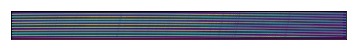

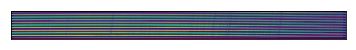

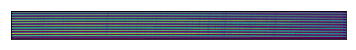

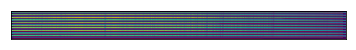

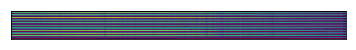

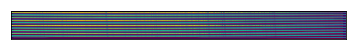

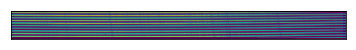

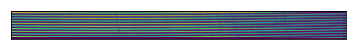

In [32]:
plt.figure()

for i in range(ntetri):
    tetras_image = tetri[i]
    plt.figure()
    plt.imshow(tetras_image)
    for j in range(17):
        plt.plot(xcoords[i],ymin_aps[i,:,j],'r-',linewidth=0.2)
    for j in range(16):
        plt.plot(xcoords[i],ymax_locs[i,:,j],'c-',linewidth=0.2)
    plt.yticks([])
    plt.xticks([])
    plt.show()
    #plt.savefig('aperature.png',dpi=1200,bbox_inches='tight', transparent="True", pad_inches=0)

In [33]:
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.interpolate import UnivariateSpline as US
def recursive_poly(x,order,params):
    if order == 0:
        return params
    elif order == 1:
        return recursive_poly(x,order-1,params[0])*x+params[-1]
    else:
        return recursive_poly(x,order-1,params[:-1])*x+params[-1]

def recursive_poly_np(x,order,params):
    return np.asarray(recursive_poly(x,order,params)).astype(np.float64)

def quad(x,a,b,c):
    return recursive_poly_np(x,2,[a,b,c])
def fourthorder(x,a,b,c,d,e):
    return recursive_poly_np(x,4,[a,b,c,d,e])
def sixthorder(x,a,b,c,d,e,f,g):
    return recursive_poly_np(x,6,[a,b,c,d,e,f,g])
def eighthorder(x,a,b,c,d,e,f,g,h,i):
    return recursive_poly_np(x,6,[a,b,c,d,e,f,g,h,i])
def tenthorder(x,a,b,c,d,e,f,g,h,i,j,k):
    return recursive_poly_np(x,6,[a,b,c,d,e,f,g,h,i,j,k])

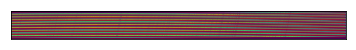

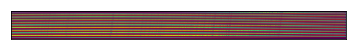

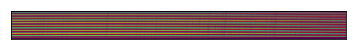

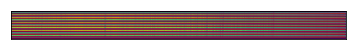

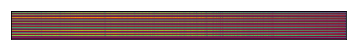

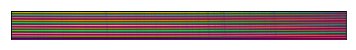

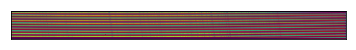

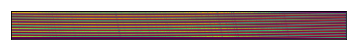

In [34]:

all_fit_params = []
all_lower_apps = []
all_upper_apps = []
all_cutouts = []
all_masks = []

fitfunc = fourthorder#sixthorder
p0 = (0.001,0.001,0.001,0.001)#,0.001,0.001,0.001,0.001,0.001,0.001)

for i in range(ntetri):
    fit_params = []
    lower_apps = []
    upper_apps = []
    cutouts = []
    masks = []
    tetris_image = tetri[i]
    xpix = np.arange(tetris_image.shape[1])
    plt.figure()
    plt.imshow(tetris_image)
    plt.yticks([])
    plt.xticks([])
    for j in range(16):
        # p1 = (*p0,10*j-5)
        # fit_min1 = curve_fit(fitfunc, xcoords[i].astype(np.float64), ymin_aps[i,:,j].astype(np.float64),p0=p1 )[0]
        # p2 = (*p0,10*j-5)
        # fit_min2 = curve_fit(fitfunc, xcoords[i].astype(np.float64), ymin_aps[i,:,j+1].astype(np.float64), p0=p2)[0]
        # p3 = (*p0,10*j)
        # fit_max  = curve_fit(fitfunc, xcoords[i].astype(np.float64), ymax_locs[i,:,j].astype(np.float64), p0=p3)[0]
        # fllows = fitfunc(xpix.astype(float),*fit_min1)
        # flhighs = fitfunc(xpix,*fit_min2)        
        # plt.plot(xpix,fitfunc(xpix,*fit_min1),'r-',linewidth=0.2)
        # plt.plot(xpix,fitfunc(xpix,*fit_min2),'r-',linewidth=0.2)
        # plt.plot(xpix,fitfunc(xpix,*fit_max),'y-',linewidth=0.2)
        # fit_params.append([fit_min1,fit_min2,fit_max])
        
        fit_min1 = US(xcoords[i].astype(np.float64),ymin_aps[i,:,j].astype(np.float64),s=3*len(xcoords[i]) )
        fit_min2 = US(xcoords[i].astype(np.float64), ymin_aps[i,:,j+1].astype(np.float64),s=3*len(xcoords[i]) )
        fit_max = US(xcoords[i].astype(np.float64), ymax_locs[i,:,j].astype(np.float64),s=3*len(xcoords[i]) )
        fllows = fit_min1(xpix)
        flhighs = fit_min2(xpix)
        plt.plot(xpix,fllows,'r-',linewidth=0.2)
        plt.plot(xpix,flhighs,'r-',linewidth=0.2)
        plt.plot(xpix,fit_max(xpix),'y-',linewidth=0.2)
        
        lows = np.floor(fllows).astype(int)
        highs = np.ceil(flhighs).astype(int)
        size = np.max(np.abs(highs-lows)).astype(int)
        cutout_array = np.zeros(shape=(size,xpix.size))
        aperature_mask = np.zeros(shape = tetris_image.shape).astype(bool)
        for low,high,x in zip(lows,highs,xpix):
            cutout_array[:np.abs(low-high),x] = tetris_image[low:high,x]
            aperature_mask[low:high,x] = True
        
        cutouts.append(cutout_array)
        masks.append(aperature_mask)
        lower_apps.append(fllows)
        upper_apps.append(flhighs)
    plt.savefig('./apps/aperaturefit{}.png'.format(i+1),dpi=800,bbox_inches='tight', transparent="True", pad_inches=0)
    all_fit_params.append(fit_params)
    all_lower_apps.append(lower_apps)
    all_upper_apps.append(upper_apps)
    all_cutouts.append(cutouts)
    all_masks.append(masks)


In [35]:
print(all_lower_apps[0][0][2])

13.0161504967


In [37]:
all_compcutouts = []
resol_factor = 100


    
for i in range(ntetri):
    lower_apps = all_lower_apps[i]
    upper_apps = all_upper_apps[i]
    comp_cutouts = []
    tetris_image = comp_tetri[i]
    hyperres = np.ndarray(shape=(tetris_image.shape[0]*resol_factor,tetris_image.shape[1]))
    for row in range(tetris_image.shape[0]):
        hyperres[resol_factor*row:resol_factor*(row+1),:] = tetris_image[row,:]/resol_factor
    
    xpix = np.arange(tetris_image.shape[1])

    for j in range(16):
        lows,highs = resol_factor*np.asarray(lower_apps[j]),resol_factor*np.asarray(upper_apps[j])
        lows = np.floor(lows).astype(int)
        highs = np.ceil(highs).astype(int)
        maxwidth = np.max(np.abs(highs-lows))+1
        cutout_array = np.zeros(shape=(maxwidth,tetris_image.shape[1]))
        cut_mid = maxwidth//2
        #plt.figure()
        #plt.plot(xpix,lows,'r-')
        #plt.plot(xpix,highs,'b-')
        
        lbs = []
        ubs = []
        for low,high,x in zip(lows,highs,xpix):
            npix = np.abs(low-high) + 1
            halfpix = npix//2
            lowerbound = cut_mid-halfpix
            upperbound = cut_mid+(npix-halfpix)
            lbs.append(lowerbound)
            ubs.append(upperbound)
            if npix == maxwidth:
                cutout_array[:,x] = hyperres[low:high+1,x]
            else:
                cutout_array[lowerbound:upperbound,x] = hyperres[low:high+1,x]
            # plt.plot(xpix,lbs,'r-.')
            # plt.plot(xpix,ubs,'b-.')
            # plt.show()
            # plt.figure()
            # plt.imshow(cutout_array)
            # plt.xticks([]), plt.yticks([])
            # plt.savefig('./apps/sci_aperaturefit{}{:02d}.png'.format(i+1,j+1),dpi=800,bbox_inches='tight', transparent="True", pad_inches=0)
            # plt.close()
            # oned = cutout_array.sum(axis=0)
            # plt.figure()
            # plt.plot(range(len(oned)),oned[::-1],'b-')
            # plt.ylim([0,np.median(oned)*3])
            # plt.show()
            # plt.close()         
        comp_cutouts.append(cutout_array)
    all_compcutouts.append(comp_cutouts)

    plt.close('all')

In [36]:
comp_copy = comparison_arc['zerod']

NameError: name 'comparison_arc' is not defined

In [48]:
reference = all_compcutouts[i][j].sum(axis=0)

zpadd_ref = np.pad(reference,[(100,0)],mode='constant',constant_values=0)

for i in range(8):
    for j in range(16):
        if i==0 and j==0:
            continue
        cutout = all_compcutouts[i][j]
        oned = cutout.sum(axis=0)
        

In [ ]:
edge_detections = np.asarray(np.abs(cv2.Sobel(comp_copy,cv2.CV_64F,1,0,ksize=3)) ).astype(np.uint8)
show_image(edge_detections)

In [47]:
np.pad?

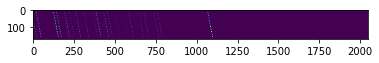

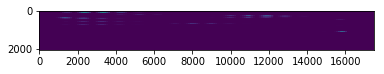

In [50]:

plt.figure()
plt.imshow(comptet)
plt.figure()
plt.imshow(hyperres.T)
plt.show()